--- Running Uniformity Test ---
Chi2: 31.95, p-value: 0.9717

--- Running Proof-of-Work Timing Test ---
Mean: 0.1172s, Std Dev: 0.1291s
K-S Test p-value: 0.2610


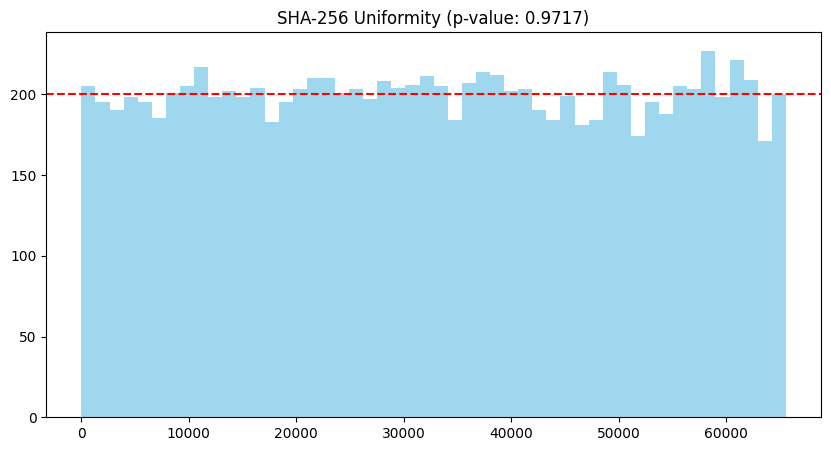

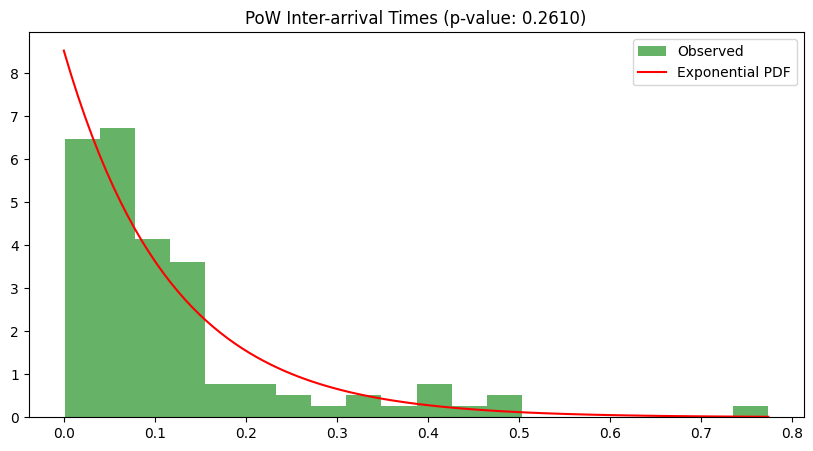

In [4]:
import hashlib
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def run_uniformity_test(n_samples=10000, n_bins=50):
    print("--- Running Uniformity Test ---")
    hashes = []
    for i in range(n_samples):
        # Hash unique inputs
        h = hashlib.sha256(f"salt_{i}".encode()).hexdigest()
        # Convert first 16 bits (4 hex chars) to integer
        hashes.append(int(h[:4], 16))

    # Statistical Test
    obs, bins = np.histogram(hashes, bins=n_bins, range=(0, 65535))
    exp = np.full(n_bins, n_samples / n_bins)
    chi2, p = stats.chisquare(f_obs=obs, f_exp=exp)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(bins[:-1], obs, width=(65535/n_bins), align='edge', color='skyblue', alpha=0.8)
    plt.axhline(y=n_samples/n_bins, color='red', linestyle='--', label='Expected')
    plt.title(f"SHA-256 Uniformity (p-value: {p:.4f})")
    plt.savefig('uniformity_dist.png')
    print(f"Chi2: {chi2:.2f}, p-value: {p:.4f}\n")

def run_pow_test(n_successes=100, difficulty=4):
    print("--- Running Proof-of-Work Timing Test ---")
    target = '0' * difficulty
    durations = []
    nonce = 0

    for i in range(n_successes):
        start = time.perf_counter()
        while True:
            h = hashlib.sha256(f"block_{nonce}".encode()).hexdigest()
            if h.startswith(target):
                durations.append(time.perf_counter() - start)
                nonce += 1
                break
            nonce += 1

    durations = np.array(durations)
    mu, sigma = np.mean(durations), np.std(durations)

    # K-S Test for Exponential distribution
    ks_stat, p_val = stats.kstest(durations, 'expon', args=(0, mu))

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.hist(durations, bins=20, density=True, color='green', alpha=0.6, label='Observed')
    x = np.linspace(0, max(durations), 100)
    plt.plot(x, stats.expon.pdf(x, scale=mu), 'r-', label='Exponential PDF')
    plt.title(f"PoW Inter-arrival Times (p-value: {p_val:.4f})")
    plt.legend()
    plt.savefig('pow_exponential_dist.png')

    print(f"Mean: {mu:.4f}s, Std Dev: {sigma:.4f}s")
    print(f"K-S Test p-value: {p_val:.4f}")

if __name__ == "__main__":
    run_uniformity_test()
    run_pow_test()

Saving plots to: /content
=== 1.1 Uniformity Test (SHA-256, first 16 bits, chi-square) ===
Samples: 10000
Bins (k): 100
Expected per bin (E): 100.00
Chi-square statistic: 93.7800
df: 99
p-value: 0.629332 (exact (SciPy))
alpha: 0.05
Decision: Fail to reject H0


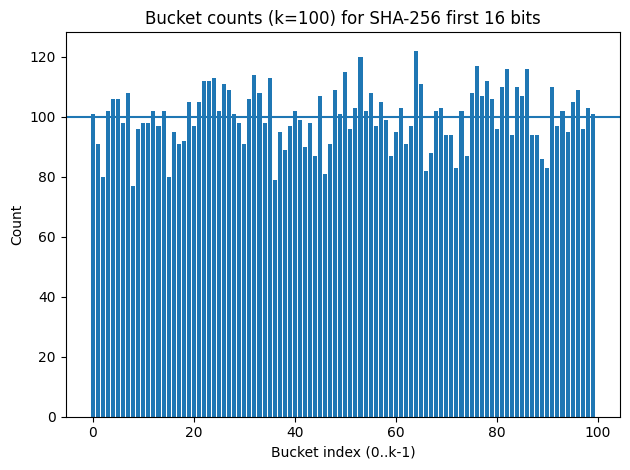

Saved plot: bucket_hist_trial1.png

=== Repeatability summary ===
Trials: 30, pattern: sequential_with_trial_prefix
p-values: min=0.035484, mean=0.490971, max=0.990633
Rejections at alpha=0.05: 1 / 30 (3.3%)
p-value method: exact (SciPy)


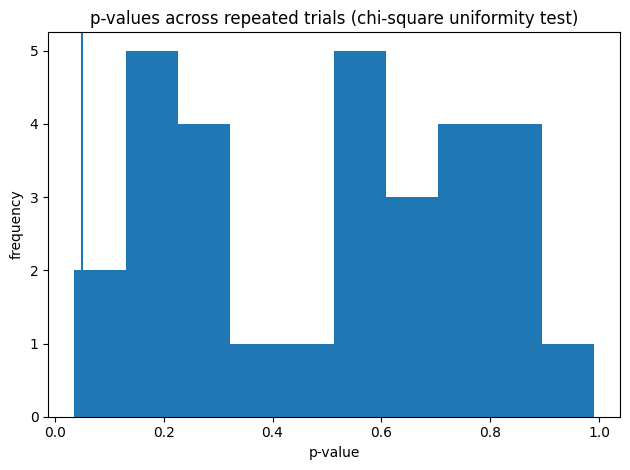

Saved plot: pvalues_repeatability.png


In [8]:
import hashlib
import math
import secrets
from typing import List, Dict, Tuple

import matplotlib.pyplot as plt

import os
print("Saving plots to:", os.getcwd())


# --- Optional: SciPy for exact p-value (recommended) ---
try:
    from scipy.stats import chi2
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False


# ---------------------------
# Hash + extraction (first 16 bits)
# ---------------------------
def sha256_first_16_bits_as_int(data: bytes) -> int:
    """
    SHA-256(data) then take the first 16 bits (first 2 bytes) as an integer in [0, 65535].
    """
    h = hashlib.sha256(data).digest()
    return int.from_bytes(h[0:2], byteorder="big", signed=False)


# ---------------------------
# Chi-square + p-value
# ---------------------------
def chi_square_statistic(observed: List[int], expected: float) -> float:
    return sum((o - expected) ** 2 / expected for o in observed)


def chi_square_pvalue(chi2_stat: float, df: int) -> Tuple[float, str]:
    """
    Returns (p_value, note). Uses SciPy if available, else Wilson–Hilferty approximation.
    """
    if SCIPY_AVAILABLE:
        p = chi2.sf(chi2_stat, df)  # upper tail probability
        return p, "exact (SciPy)"
    # Wilson–Hilferty transform (good for df >= ~30)
    z = ((chi2_stat / df) ** (1 / 3) - (1 - 2 / (9 * df))) / math.sqrt(2 / (9 * df))
    p = 0.5 * math.erfc(z / math.sqrt(2))
    return p, "approx (no SciPy)"


# ---------------------------
# Bucketing (k bins over 0..65535)
# ---------------------------
def bucket_index(v: int, k_bins: int) -> int:
    """
    Map v in [0,65535] into [0, k_bins-1] using equal-width bins.
    """
    width = 65536 / k_bins
    idx = int(v / width)
    return min(idx, k_bins - 1)


# ---------------------------
# Input generation (repeatability)
# ---------------------------
def generate_inputs(num_samples: int, pattern: str, trial_id: int) -> List[bytes]:
    """
    Generate num_samples unique inputs as bytes, depending on pattern:
    - "sequential": b"input1", b"input2", ...
      NOTE: deterministic -> repeating trials gives identical results.
    - "sequential_with_trial_prefix": b"trial{trial_id}|input1", ...
    - "random_hex": random 16-byte tokens + index (unique with overwhelming probability)
    """
    if pattern == "sequential":
        return [f"input{i}".encode("utf-8") for i in range(1, num_samples + 1)]

    if pattern == "sequential_with_trial_prefix":
        prefix = f"trial{trial_id}|".encode("utf-8")
        return [prefix + f"input{i}".encode("utf-8") for i in range(1, num_samples + 1)]

    if pattern == "random_hex":
        # Use secrets for good randomness; attach i to guarantee uniqueness
        out = []
        for i in range(1, num_samples + 1):
            tok = secrets.token_hex(16).encode("utf-8")  # 32 hex chars
            out.append(tok + b"|" + str(i).encode("utf-8"))
        return out

    raise ValueError(f"Unknown pattern: {pattern}")


# ---------------------------
# One trial: your exact method
# ---------------------------
def run_trial(num_samples: int = 10_000, k_bins: int = 100, alpha: float = 0.05,
              pattern: str = "sequential_with_trial_prefix", trial_id: int = 1) -> Dict:
    inputs = generate_inputs(num_samples, pattern, trial_id)

    observed = [0] * k_bins
    for x in inputs:
        v = sha256_first_16_bits_as_int(x)
        observed[bucket_index(v, k_bins)] += 1

    expected = num_samples / k_bins
    chi2_stat = chi_square_statistic(observed, expected)
    df = k_bins - 1
    p_value, p_note = chi_square_pvalue(chi2_stat, df)

    return {
        "trial_id": trial_id,
        "pattern": pattern,
        "num_samples": num_samples,
        "k_bins": k_bins,
        "expected": expected,
        "observed": observed,
        "chi2_stat": chi2_stat,
        "df": df,
        "p_value": p_value,
        "p_note": p_note,
        "alpha": alpha,
        "reject_H0": (p_value < alpha),
    }


# ---------------------------
# Plotting
# ---------------------------
def plot_bucket_histogram(observed, expected, title, filename):
    plt.figure()
    xs = list(range(len(observed)))
    plt.bar(xs, observed)
    plt.axhline(expected)
    plt.title(title)
    plt.xlabel("Bucket index (0..k-1)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(filename, dpi=160)
    plt.show()
    plt.close()



def plot_pvalues(p_values: List[float], alpha: float, title: str, filename: str):
    plt.figure()
    plt.hist(p_values, bins=10)
    plt.axvline(alpha)
    plt.title(title)
    plt.xlabel("p-value")
    plt.ylabel("frequency")
    plt.tight_layout()
    plt.savefig(filename, dpi=160)
    plt.show()
    plt.close()


# ---------------------------
# Repeatability runner
# ---------------------------
def run_repeatability(trials: int = 20,
                      num_samples: int = 10_000,
                      k_bins: int = 100,
                      alpha: float = 0.05,
                      pattern: str = "sequential_with_trial_prefix"):
    results = []
    for t in range(1, trials + 1):
        results.append(run_trial(num_samples, k_bins, alpha, pattern, trial_id=t))

    pvals = [r["p_value"] for r in results]
    rejects = sum(1 for r in results if r["reject_H0"])

    summary = {
        "trials": trials,
        "pattern": pattern,
        "alpha": alpha,
        "rejects": rejects,
        "reject_rate": rejects / trials,
        "p_min": min(pvals),
        "p_max": max(pvals),
        "p_mean": sum(pvals) / len(pvals),
        "p_note": results[0]["p_note"] if results else "",
    }
    return results, summary


# ---------------------------
# Main (edit these values as you like)
# ---------------------------
if __name__ == "__main__":
    # --- Single trial (for your main report figure) ---
    single = run_trial(
        num_samples=10_000,
        k_bins=100,
        alpha=0.05,
        pattern="sequential_with_trial_prefix",  # recommended for repeatability
        trial_id=1
    )

    print("=== 1.1 Uniformity Test (SHA-256, first 16 bits, chi-square) ===")
    print(f"Samples: {single['num_samples']}")
    print(f"Bins (k): {single['k_bins']}")
    print(f"Expected per bin (E): {single['expected']:.2f}")
    print(f"Chi-square statistic: {single['chi2_stat']:.4f}")
    print(f"df: {single['df']}")
    print(f"p-value: {single['p_value']:.6f} ({single['p_note']})")
    print(f"alpha: {single['alpha']}")
    print("Decision:", "Reject H0" if single["reject_H0"] else "Fail to reject H0")

    plot_bucket_histogram(
        single["observed"],
        single["expected"],
        title="Bucket counts (k=100) for SHA-256 first 16 bits",
        filename="bucket_hist_trial1.png"
    )
    print("Saved plot: bucket_hist_trial1.png")

    # --- Repeatability: multiple trials (changing inputs across trials) ---
    results, summary = run_repeatability(
        trials=30,
        num_samples=10_000,
        k_bins=100,
        alpha=0.05,
        pattern="sequential_with_trial_prefix"
        # alternatives:
        # pattern="sequential"   (will repeat identical results each trial)
        # pattern="random_hex"   (random each time)
    )

    print("\n=== Repeatability summary ===")
    print(f"Trials: {summary['trials']}, pattern: {summary['pattern']}")
    print(f"p-values: min={summary['p_min']:.6f}, mean={summary['p_mean']:.6f}, max={summary['p_max']:.6f}")
    print(f"Rejections at alpha={summary['alpha']}: {summary['rejects']} / {summary['trials']} "
          f"({summary['reject_rate']*100:.1f}%)")
    print(f"p-value method: {summary['p_note']}")

    plot_pvalues(
        [r["p_value"] for r in results],
        alpha=summary["alpha"],
        title="p-values across repeated trials (chi-square uniformity test)",
        filename="pvalues_repeatability.png"
    )
    print("Saved plot: pvalues_repeatability.png")
